In [5]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import os

from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Data Mining/Data/data_all.csv'

In [8]:
os.listdir(data_path)

['Previous',
 'Data_Keni.csv',
 'lavanya-apr-20.csv',
 'Xinya.csv',
 '0420data_Zhiquan.csv',
 'df_Grace.csv',
 'df_full.csv',
 'data_all.csv']

In [17]:
df_full = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Mining_Sheila/Data/Copy of df2022_WiClass.csv')
Features = ['SDHTRNSP', 'SDHSTRE1', 'MARIJAN1', 'MARJSMOK', 'MARJEAT', 'MARJVAPE', 'MARJDAB', 'MARJOTHR', 'USEMRJN4', 'LASTSMK2',
             'STOPSMK2', 'MENTCIGS', 'MENTECIG', 'HEATTBCO', 'ASBIALCH', 'ASBIDRNK', 'ASBIBING', 'ASBIADVC', 'ASBIRDUC', 'FIREARM5',
             'GUNLOAD', 'LOADULK2', 'RCSGEND1', 'RCSXBRTH', 'RCSRLTN2', 'CASTHDX2', 'CASTHNO2', 'BIRTHSEX', 'SOMALE', 'SOFEMALE',
             'TRNSGNDR', 'HADSEX', 'PFPPRVN4', 'TYPCNTR9', 'BRTHCNT4', 'WHEREGET', 'NOBCUSE8', 'BCPREFER', 'RRCLASS3', 'RRCOGNT2',
             'RRTREAT', 'RRATWRK2', 'RRHCARE4', 'RRPHYSM2', 'QSTVER', 'QSTLANG', '_METSTAT', '_URBSTAT', 'MSCODE', '_STSTR', '_STRWT',
             '_RAWRAKE', '_WT2RAKE', '_IMPRACE', '_CHISPNC', '_CRACE2', '_CPRACE2', 'CAGEG', '_CLLCPWT', '_DUALUSE', '_DUALCOR', '_LLCPWT2',
             '_LLCPWT', '_RFHLTH', '_PHYS14D', '_MENT14D', '_HLTHPLN', 'SDHUTILS','Class']
df = df_full[Features]

In [10]:
df.head()

,SDHTRNSP,SDHSTRE1,MARIJAN1,MARJSMOK,MARJEAT,MARJVAPE,MARJDAB,MARJOTHR,USEMRJN4,LASTSMK2,...,_DUALUSE,_DUALCOR,_LLCPWT2,_LLCPWT,_RFHLTH,_PHYS14D,_MENT14D,_HLTHPLN,SDHUTILS,Class
0,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.512057,1353.835815,476.119129,1.0,1.0,1.0,1.0,2.0,Mild CD
1,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,NaN,2990.459212,1698.893053,1.0,1.0,1.0,2.0,1.0,No CD
2,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.512057,676.917907,217.916893,1.0,2.0,9.0,1.0,2.0,Mild CD
3,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,...,1.0,0.512057,676.917907,234.581986,1.0,1.0,1.0,1.0,2.0,No CD
4,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,NaN,4361.653075,2177.534520,2.0,2.0,2.0,1.0,2.0,No CD


In [11]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2, pvalue, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [39]:
#@title Function for binary variable exploration
def explore_binary(df, feature, include_refused=False):
  print(f'There are {df[feature].isna().sum()} missing values, {np.sum(df[feature]==7)} not sure, {np.sum(df[feature]==9)} refused')
  if np.sum(~df[feature].isna()) == 0:
    print("No valid information")
  else:
    subdf = df[[feature, 'Class']]
    subdf['Binary Classification'] = subdf['Class'].replace({'Mild CD':'CD', 'Moderate CD':'CD', 'Severe CD':'CD'})
    if not include_refused:
      subdf = subdf[(subdf[feature] == 1) | (subdf[feature] == 2)]
      subdf[feature] = subdf[feature].replace({1:'Yes', 2: 'No'})

      desired_order = ['Mild CD', 'Moderate CD', 'Severe CD']
      grouped = subdf.groupby([feature, 'Class']).size().unstack()
      grouped = grouped[desired_order]
      frequencies = grouped.div(grouped.sum(axis=1), axis=0)

      desired_order2 = ['CD', 'No CD']
      grouped2 = subdf.groupby([feature, 'Binary Classification']).size().unstack()
      grouped2 = grouped2[desired_order2]
      frequencies2 = grouped2.div(grouped2.sum(axis=1), axis=0)

      idx_order = ['Yes', 'No']
      frequencies=frequencies.reindex(idx_order)
      frequencies2=frequencies2.reindex(idx_order)

      fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

      frequencies.plot(kind='bar', width=0.35, ax=axes[0])
      axes[0].set_xlabel(f'{feature}', fontsize=12)
      axes[0].set_ylabel('Distribution', fontsize=12)
      axes[0].set_title(f'Distribution of CD Classes by {feature}', fontsize=14)
      axes[0].legend(title=f'{feature}', labels=desired_order, loc='upper right')
      axes[0].set_xticklabels(idx_order, rotation=0)

      frequencies2.plot(kind='bar', width=0.35, ax=axes[1])
      axes[1].set_xlabel(f'{feature}', fontsize=12)
      axes[1].set_ylabel('Distribution', fontsize=12)
      axes[1].set_title(f'Binary CD by {feature}', fontsize=14)
      axes[1].legend(title=f'{feature}', labels=desired_order2, loc='upper right')
      axes[1].set_xticklabels(idx_order, rotation=0)
      print()

      # Show plot
      plt.tight_layout()
      plt.show()

      cv1 = cramers_v(subdf[~(subdf['Class']=='No CD')][feature], subdf[~(subdf['Class']=='No CD')]['Class'])
      print(f'Cramers V for multi-class classification is: {cv1}')

      cv2 = cramers_v(subdf[feature], subdf['Binary Classification'])
      print(f'Cramers V for binary classification is: {cv2}')

    else:
      subdf = subdf[(subdf[feature] == 1) | (subdf[feature] == 2)| (subdf[feature] == 7)| (subdf[feature] == 9)]
      subdf[feature] = subdf[feature].replace({1:'Yes', 2: 'No', 7: 'Not Sure', 9: 'Refused'})

      desired_order = ['Mild CD', 'Moderate CD', 'Severe CD']
      grouped = subdf.groupby([feature, 'Class']).size().unstack()
      grouped.fillna(0, inplace=True)
      grouped = grouped[desired_order]
      frequencies = grouped.div(grouped.sum(axis=1), axis=0)

      desired_order2 = ['CD', 'No CD']
      grouped2 = subdf.groupby([feature, 'Binary Classification']).size().unstack()
      grouped2 = grouped2[desired_order2]
      frequencies2 = grouped2.div(grouped2.sum(axis=1), axis=0)

      idx_order = ['Yes', 'No', 'Not Sure', 'Refused']
      frequencies=frequencies.reindex(idx_order)
      frequencies2=frequencies2.reindex(idx_order)

      fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

      frequencies.plot(kind='bar', width=0.35, ax=axes[0])
      axes[0].set_xlabel(f'{feature}', fontsize=12)
      axes[0].set_ylabel('Distribution', fontsize=12)
      axes[0].set_title(f'Distribution of CD Classes by {feature}', fontsize=14)
      axes[0].legend(title=f'{feature}', labels=desired_order, loc='upper right')
      axes[0].set_xticklabels(idx_order, rotation=0)

      frequencies2.plot(kind='bar', width=0.35, ax=axes[1])
      axes[1].set_xlabel(f'{feature}', fontsize=12)
      axes[1].set_ylabel('Distribution', fontsize=12)
      axes[1].set_title(f'Binary CD by {feature}', fontsize=14)
      axes[1].legend(title=f'{feature}', labels=desired_order2, loc='upper right')
      axes[1].set_xticklabels(idx_order, rotation=0)

      # Show plot
      plt.tight_layout()
      plt.show()

      cv1 = cramers_v(subdf[~(subdf['Class']=='No CD')][feature], subdf[~(subdf['Class']=='No CD')]['Class'])
      print(f'Cramers V for multi-class classification is: {cv1}')

      cv2 = cramers_v(subdf[feature], subdf['Binary Classification'])
      print(f'Cramers V for binary classification is: {cv2}')

  return frequencies2

There are 0 missing values, 322 not sure, 70 refused



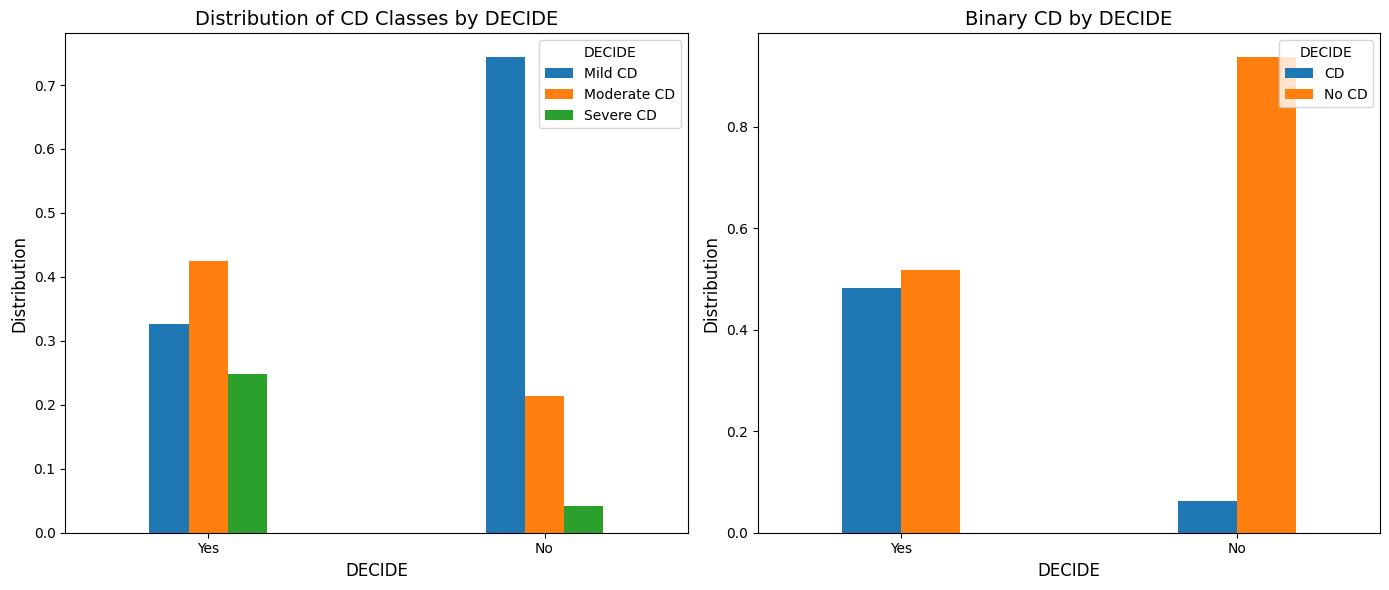

Cramers V for multi-class classification is: 0.43636442637918843
Cramers V for binary classification is: 0.4076296382456461


Binary Classification,CD,No CD
DECIDE,,
Yes,0.482815,0.517185
No,0.063151,0.936849


In [40]:
# 201 Has a lack of reliable transportation kept you from appointments, meetings, work, or getting things needed?
explore_binary(df_full, 'DECIDE')

There are 0 missing values, 71 not sure, 21 refused



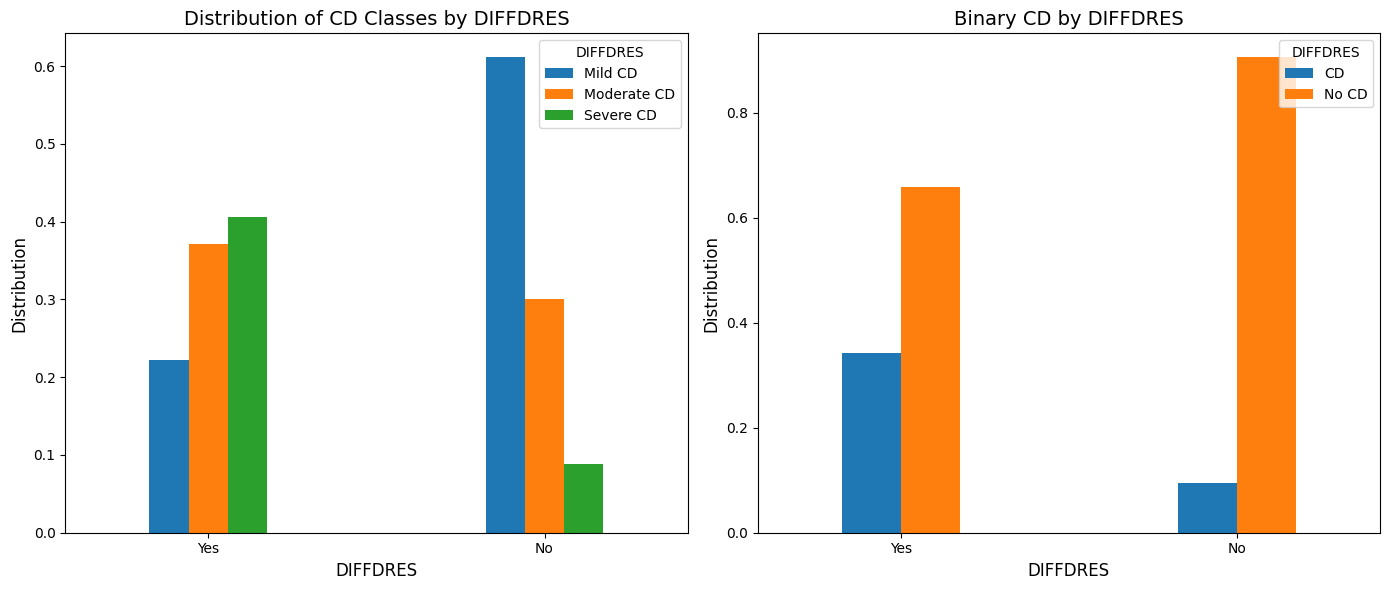

Cramers V for multi-class classification is: 0.35764130817670553
Cramers V for binary classification is: 0.16558544949858434


Binary Classification,CD,No CD
DIFFDRES,,
Yes,0.341420,0.658580
No,0.094031,0.905969


In [79]:
# 52  (Ever told) (you had) a depressive disorder (including depression, major depression, dysthymia, or minor depression)?
explore_binary(df_full, 'DIFFDRES', include_refused=False)

In [ ]:
#204 Did you smoke marijuana or cannabis?
explore_binary(df, 'MARJSMOK', include_refused=True)

In [ ]:
#205 Did you eat marijuana or cannabis?
explore_binary(df, 'MARJEAT', include_refused=True)

In [ ]:
#206 Did you vape marijuana or cannabis?
explore_binary(df, 'MARJVAPE', include_refused=True)

In [ ]:
#207 Did you dab marijuana or cannabis?
explore_binary(df, 'MARJDAB', include_refused=True)

In [ ]:
#208 Did you use marijuana or cannabis some other way?
explore_binary(df, 'MARJOTHR', include_refused=True)

In [ ]:
# 211 Stopped Smoking in past 12 months
explore_binary(df, 'STOPSMK2', include_refused=True)

In [ ]:
# 212 Do you usually smoke menthol cigarettes?
explore_binary(df, 'MENTCIGS', include_refused=False)

In [ ]:
#213 Do you usually use menthol e-cigarettes?
explore_binary(df, 'MENTECIG', include_refused=False)

There are 0 missing values, 322 not sure, 70 refused


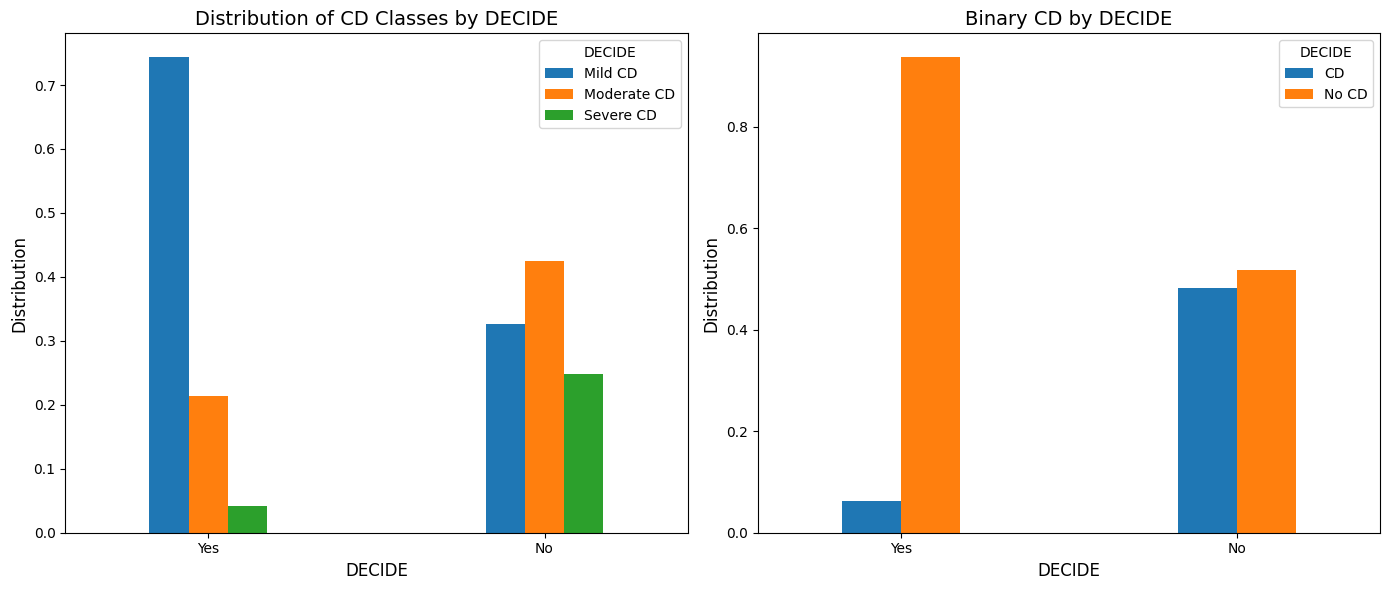

Cramers V for multi-class classification is: 0.43636442637918843
Cramers V for binary classification is: 0.4076296382456461


In [18]:
explore_binary(df_full, 'DECIDE', include_refused=False)


In [41]:
#@title Function for categorical variable exploration
# mapping = {1:'Always', 2:"Usually",..., 7:"Not Sure", 9:"Refused"}
def explore_cat(df, feature, mapping, include_refused=False):
  subdf = df[[feature, 'Class']]
  subdf[feature] = subdf[feature].replace(mapping)
  print(f'There are {df[feature].isna().sum()} missing values, {np.sum(subdf[feature]=="Not Sure")} not sure values, {np.sum(subdf[feature]=="Refused")} refused values')
  if np.sum(~df[feature].isna()) == 0:
    print("No valid information")

  else:
    subdf.dropna(subset = [feature], inplace=True)
    subdf['Binary Classification'] = subdf['Class'].replace({'Mild CD':'CD', 'Moderate CD':'CD', 'Severe CD':'CD'})

    if not include_refused:
      subdf = subdf[~((subdf[feature] == 'Not Sure') | (subdf[feature] == 'Refused'))]

      desired_order = ['Mild CD', 'Moderate CD', 'Severe CD']
      grouped = subdf.groupby([feature, 'Class']).size().unstack()
      grouped = grouped[desired_order]
      frequencies = grouped.div(grouped.sum(axis=1), axis=0)

      desired_order2 = ['CD', 'No CD']
      grouped2 = subdf.groupby([feature, 'Binary Classification']).size().unstack()
      grouped2 = grouped2[desired_order2]
      frequencies2 = grouped2.div(grouped2.sum(axis=1), axis=0)

      idx_order = list(mapping.values())[:-2]
      frequencies=frequencies.reindex(idx_order)
      frequencies2=frequencies2.reindex(idx_order)

      fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

      frequencies.plot(kind='bar', width=0.35, ax=axes[0])
      axes[0].set_xlabel(f'{feature}', fontsize=12)
      axes[0].set_ylabel('Distribution', fontsize=12)
      axes[0].set_title(f'Distribution of CD Classes by {feature}', fontsize=14)
      axes[0].legend(title=f'{feature}', labels=desired_order, loc='upper right')
      axes[0].set_xticklabels(idx_order, rotation=0)

      frequencies2.plot(kind='bar', width=0.35, ax=axes[1])
      axes[1].set_xlabel(f'{feature}', fontsize=12)
      axes[1].set_ylabel('Distribution', fontsize=12)
      axes[1].set_title(f'Binary CD by {feature}', fontsize=14)
      axes[1].legend(title=f'{feature}', labels=desired_order2, loc='upper right')
      axes[1].set_xticklabels(idx_order, rotation=0)

      # Show plot
      plt.tight_layout()
      plt.show()

      cv1 = cramers_v(subdf[~(subdf['Class']=='No CD')][feature], subdf[~(subdf['Class']=='No CD')]['Class'])
      print(f'Cramers V for multi-class classification is: {cv1}')

      cv2 = cramers_v(subdf[feature], subdf['Binary Classification'])
      print(f'Cramers V for binary classification is: {cv2}')

    else:
      desired_order = ['Mild CD', 'Moderate CD', 'Severe CD']
      grouped = subdf.groupby([feature, 'Class']).size().unstack()
      grouped.fillna(0, inplace=True)
      grouped = grouped[desired_order]
      frequencies = grouped.div(grouped.sum(axis=1), axis=0)

      desired_order2 = ['CD', 'No CD']
      grouped2 = subdf.groupby([feature, 'Binary Classification']).size().unstack()
      grouped2 = grouped2[desired_order2]
      frequencies2 = grouped2.div(grouped2.sum(axis=1), axis=0)

      idx_order = list(mapping.values())
      frequencies=frequencies.reindex(idx_order)
      frequencies2=frequencies2.reindex(idx_order)

      fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

      frequencies.plot(kind='bar', width=0.35, ax=axes[0])
      axes[0].set_xlabel(f'{feature}', fontsize=12)
      axes[0].set_ylabel('Distribution', fontsize=12)
      axes[0].set_title(f'Distribution of CD Classes by {feature}', fontsize=14)
      axes[0].legend(title=f'{feature}', labels=desired_order, loc='upper right')
      axes[0].set_xticklabels(idx_order, rotation=0)

      frequencies2.plot(kind='bar', width=0.35, ax=axes[1])
      axes[1].set_xlabel(f'{feature}', fontsize=12)
      axes[1].set_ylabel('Distribution', fontsize=12)
      axes[1].set_title(f'Binary CD by {feature}', fontsize=14)
      axes[1].legend(title=f'{feature}', labels=desired_order2, loc='upper right')
      axes[1].set_xticklabels(idx_order, rotation=0)

      # Show plot
      plt.tight_layout()
      plt.show()

      cv1 = cramers_v(subdf[~(subdf['Class']=='No CD')][feature], subdf[~(subdf['Class']=='No CD')]['Class'])
      print(f'Cramers V for multi-class classification is: {cv1}')

      cv2 = cramers_v(subdf[feature], subdf['Binary Classification'])
      print(f'Cramers V for binary classification is: {cv2}')

In [ ]:
# # sample function usage
# # mapping = {1:"Gay", 2: "Straight", 3: "Bi", 4:"Others", 7: "Not Sure", 9: "Refused"}
# mapping = {1: 'White', 2: 'Black', 3: 'Hispanic', 4: 'Asian', 5: 'Native Hawaiian', 6: 'American Indian', 7: 'Mixed', 8:'Others',
#             77: "Not Sure", 99: "Refused"}
# #mapping = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 7: "Not Sure", 9: "Refused"}
# feature = 'RRCLASS3'

# explore_cat(df_full, feature, mapping, include_refused=False)

There are 10992 missing values, 348 not sure values, 131 refused values


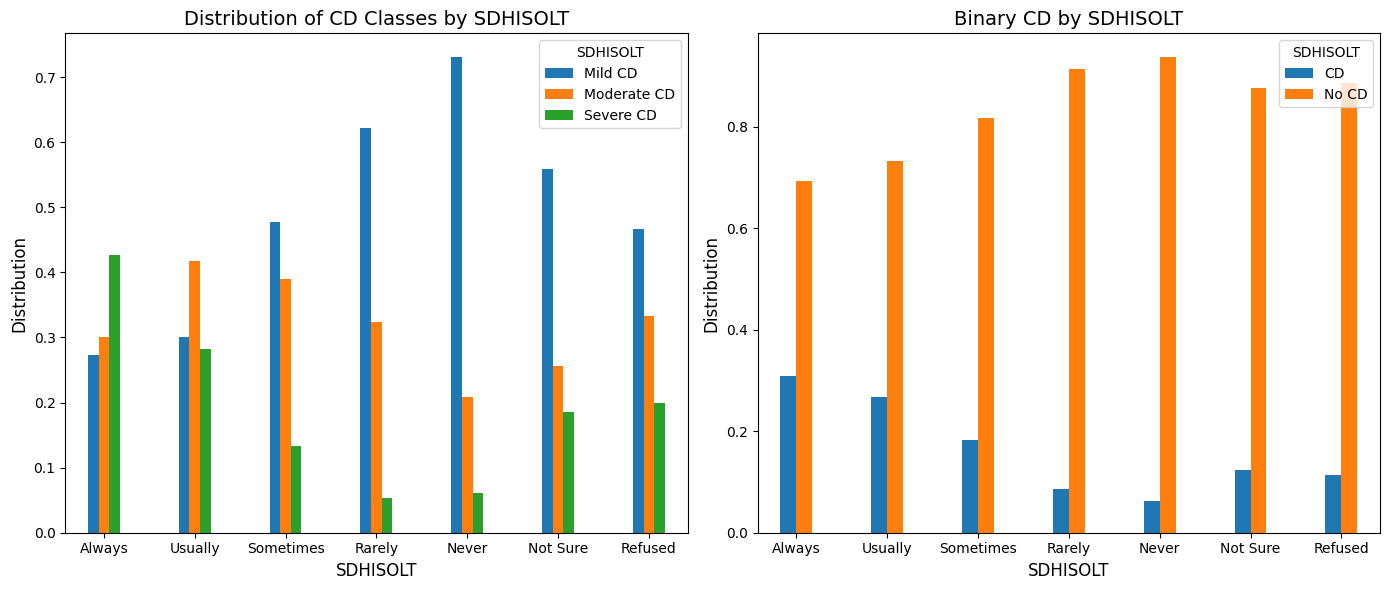

Cramers V for multi-class classification is: 0.2721837696519268
Cramers V for binary classification is: 0.20884010594896135


In [42]:
mapping = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 7: "Not Sure", 9: "Refused"}
explore_cat(df_full, 'SDHISOLT', mapping, include_refused=True)

In [ ]:
mapping239 = {1: 'White', 2: 'Black', 3: 'Hispanic', 4: 'Asian', 5: 'Native Hawaiian', 6: 'American Indian', 7: 'Mixed', 8:'Others',77: "Not Sure", 99: "Refused"}
explore_cat(df_full, 'RRCLASS3', mapping239, include_refused=False)

There are 58433 missing values, 66 not sure values, 260 refused values


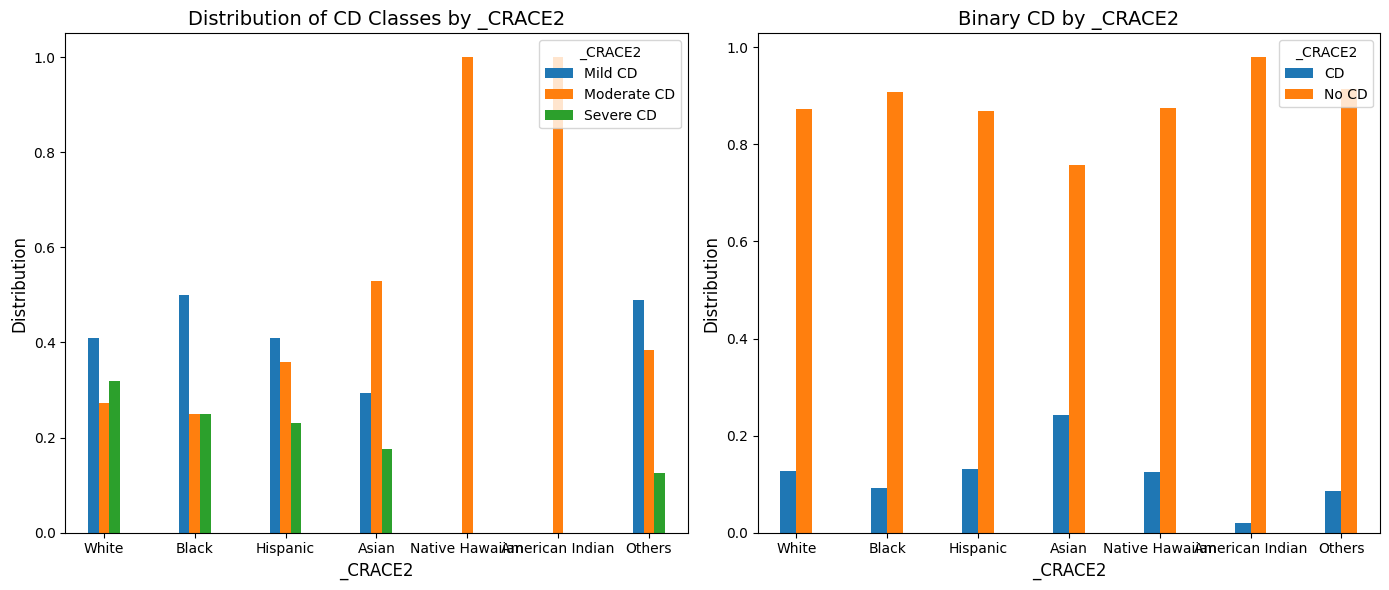

Cramers V for multi-class classification is: 0.07443907721652719
Cramers V for binary classification is: 0.0726128093239177


In [ ]:
mapping255 = {1: 'White', 2: 'Black', 3: 'Hispanic', 4: 'Asian', 5: 'Native Hawaiian', 6: 'American Indian', 88:'Others',77: "Not Sure", 99: "Refused"}
explore_cat(df_full, '_CRACE2', mapping255, include_refused=False)

There are 58483 missing values, 0 not sure values, 0 refused values


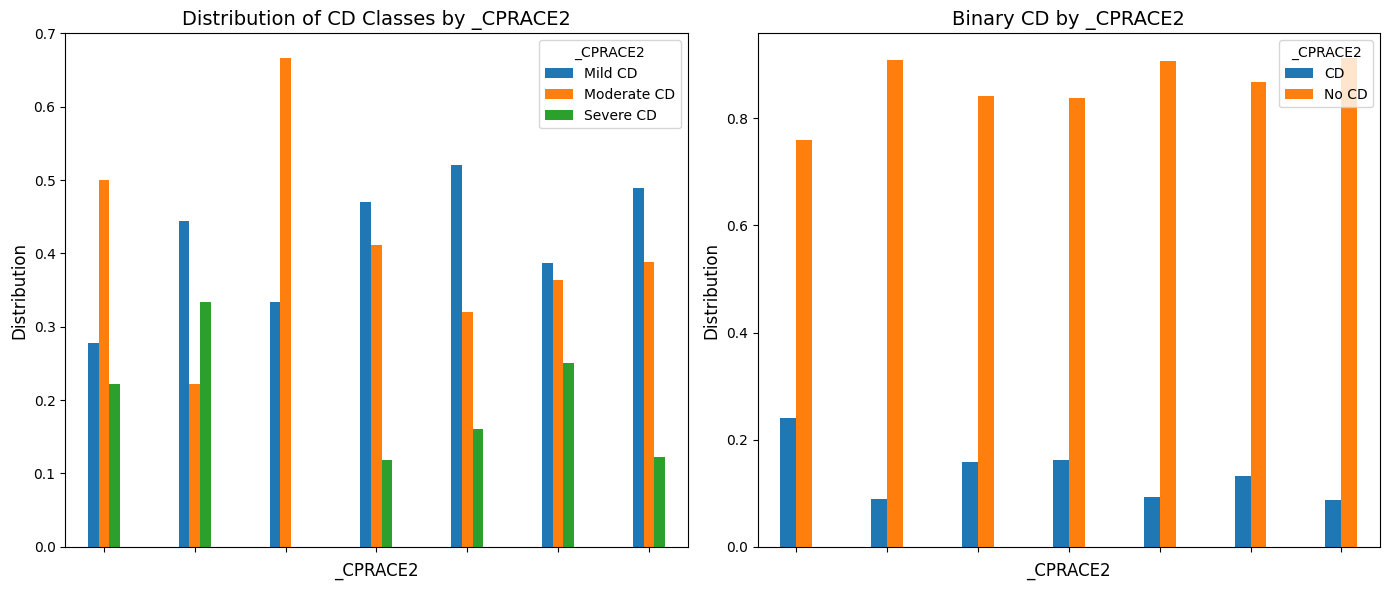

Cramers V for multi-class classification is: 0.03352311011803778
Cramers V for binary classification is: 0.07323666478529386


In [ ]:
mapping257  = {1: 'White', 2: 'Black'}
explore_cat(df_full, '_CPRACE2', mapping257 , include_refused=False)

There are 20830 missing values, 0 not sure values, 0 refused values


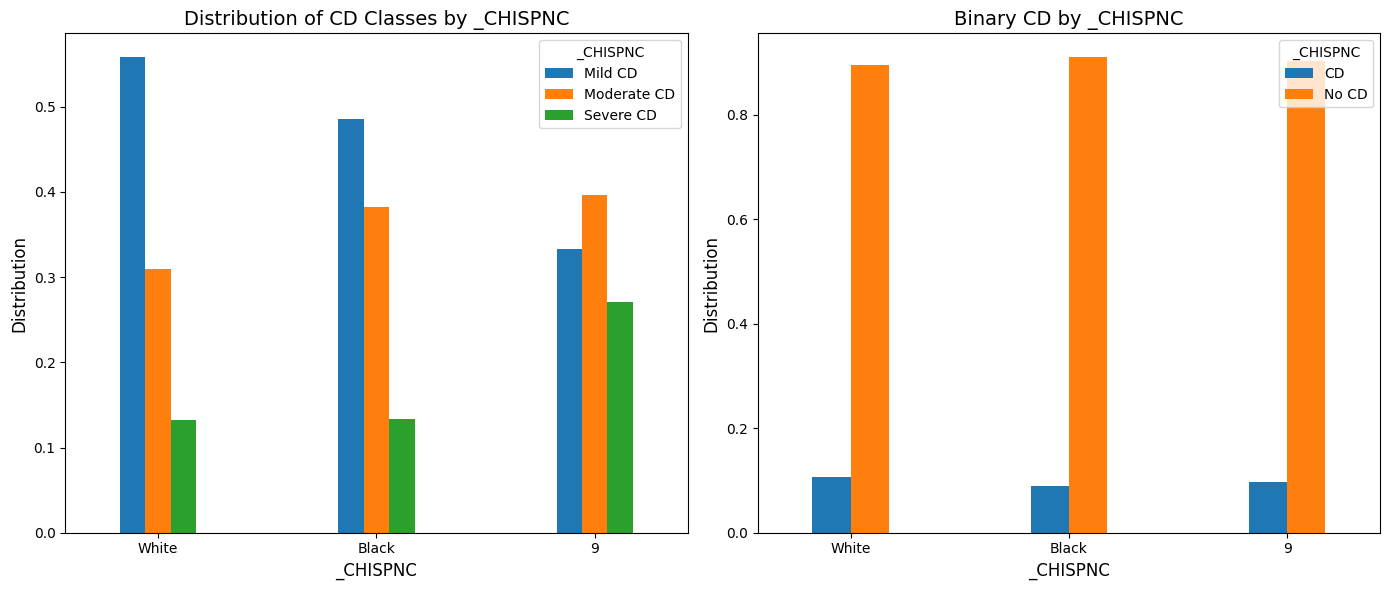

Cramers V for multi-class classification is: 0.04415013086542294
Cramers V for binary classification is: 0.01446567221763063


In [ ]:
mapping254 = {1: 'White', 2: 'Black',9:'9'}
explore_cat(df_full, '_CHISPNC', mapping254, include_refused=True)

In [ ]:
mapping240 = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 6:"6", 7: "Not Sure", 8:"8",9: "Refused"}
explore_cat(df_full, 'RRCOGNT2', mapping240, include_refused=True)

There are 11437 missing values, 163 not sure values, 98 refused values


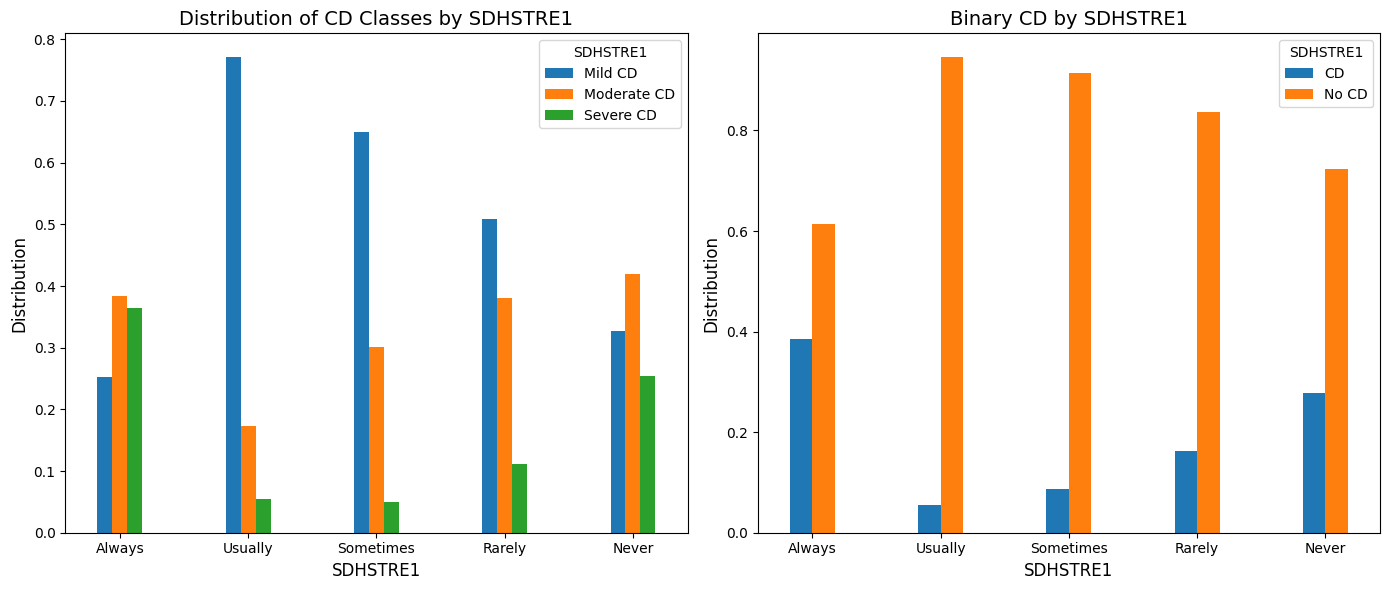

Cramers V for multi-class classification is: 0.28611406134971007
Cramers V for binary classification is: 0.24858920599790318


In [ ]:
#202 How often have you felt this kind of stress?
mapping = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 7: "Not Sure", 9: "Refused"}
explore_cat(df_full, 'SDHSTRE1', mapping, include_refused=False)

In [ ]:
#210 How long has it been since you last smoked a cigarette, even one or two puffs?
mapping210 = {1:"<1 month", 2: "1-3 months", 3: "3-6 months", 4:"6-12 months", 5:"1-5 years", 6: "5-10 years",7: "10 years or more", 8: "Never smoked", 77: "Don't Know", 99: "Refused"}
explore_cat(df_full, 'LASTSMK2', mapping210, include_refused=True)

There are 0 missing values, 0 not sure values, 2149 refused values


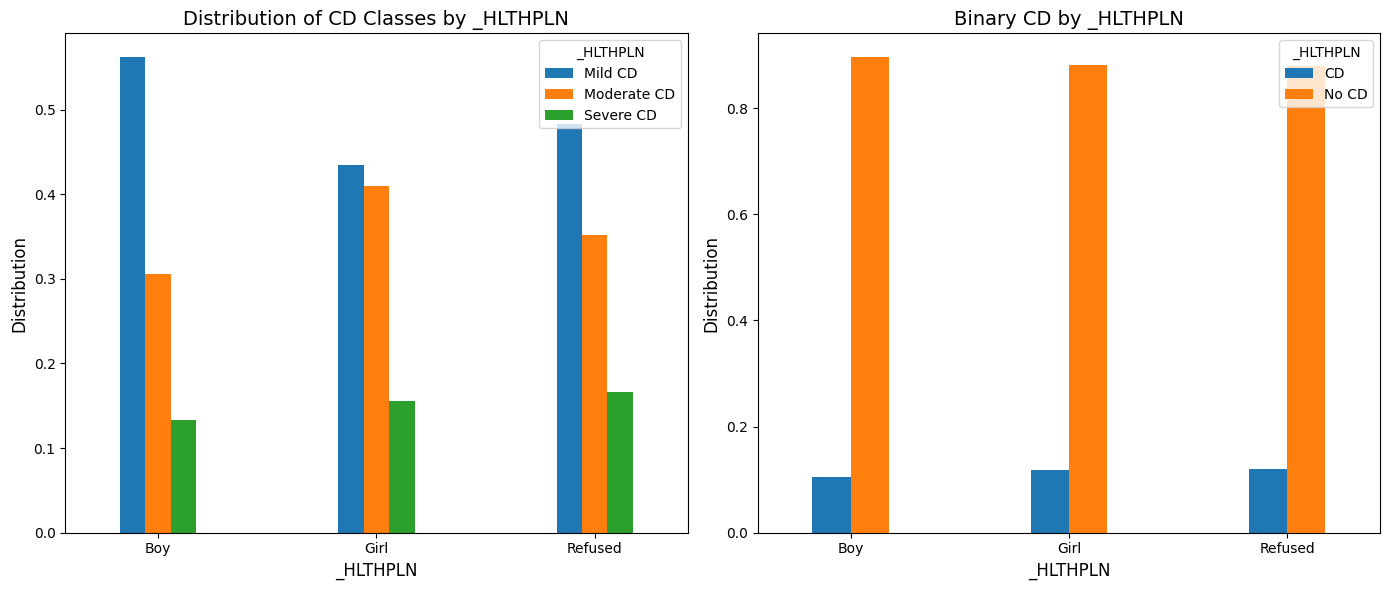

Cramers V for multi-class classification is: 0.03414715252184496
Cramers V for binary classification is: 0.0106754798283473


In [ ]:
mapping224 = {1:"Boy", 2: "Girl", 9: "Refused"}
explore_cat(df_full, '_HLTHPLN', mapping224, include_refused=True)


In [ ]:
mapping229 = {1:"Gay", 2: "Straight", 3: "Bi", 4:"Others", 7: "Not Sure", 9: "Refused"}
explore_cat(df_full, 'TRNSGNDR', mapping229, include_refused=True)


There are 10861 missing values, 327 not sure values, 134 refused values


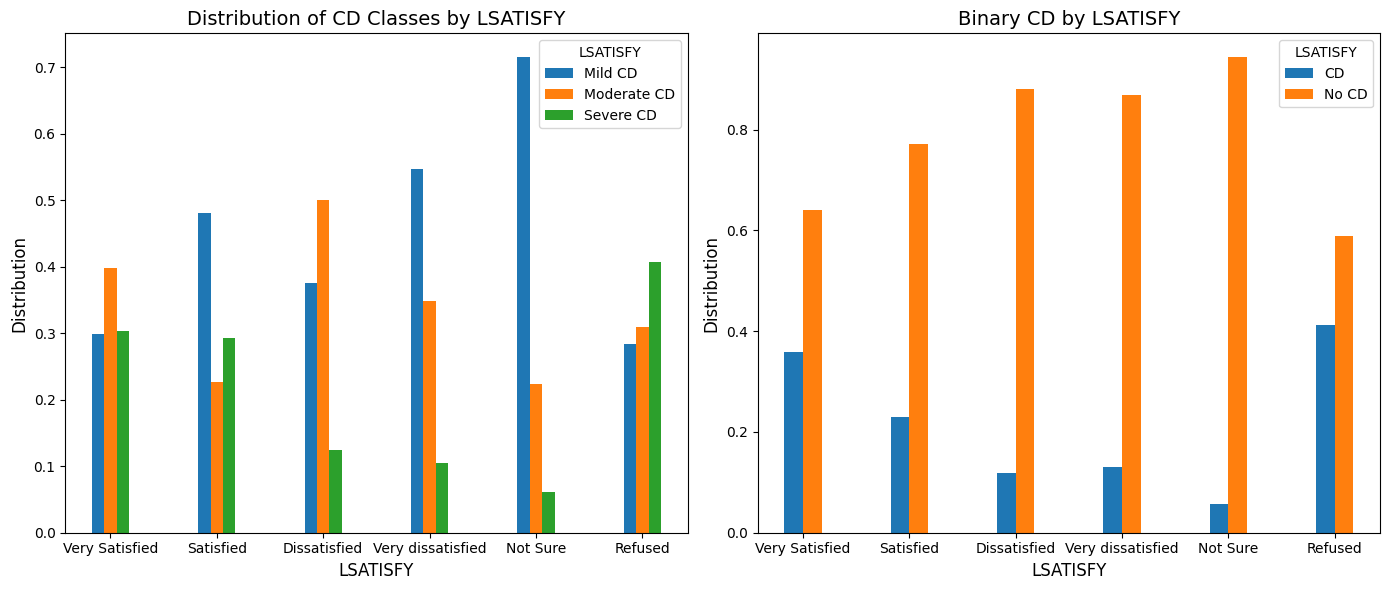

Cramers V for multi-class classification is: 0.23375208358295535
Cramers V for binary classification is: 0.22738749083164822


In [ ]:
mapping_ls = {1:"Very Satisfied", 2: "Satisfied", 3: "Dissatisfied", 4:"Very dissatisfied", 7: "Not Sure", 9: "Refused"}
explore_cat(df_full, 'LSATISFY', mapping_ls, include_refused=True)


In [ ]:
mapping = {1:"Always", 2: "Usually", 3: "Sometimes", 4:"Rarely", 5:"Never", 6:"6",7: "Not Sure", 9: "Refused"}
explore_cat(df_full, 'RRHCARE4', mapping, include_refused=False)

In [ ]:
mapping210 = {0:"0",1:"1", 2: "2", 3: "3", 4:"4", 5:"5", 6: "6",7: "7", 8: "8",9:"9",10:"10",11:"11",12:"12", 77: "Don't Know", 99: "Refused"}
explore_cat(df_full, 'BRTHCNT4', mapping210, include_refused=False)

In [ ]:
mapping237 = {0:"0",1:"1", 2: "2", 3: "3", 4:"4", 5:"5", 6: "6",7: "7", 8: "8",9:"9",10:"10",11:"11",12:"12",13:"13", 77: "Don't Know", 99: "Refused"}
explore_cat(df_full, 'BCPREFER', mapping237, include_refused=True)

In [ ]:
mapping248 = {1:"1", 2: "2", 3: "3", 5:"5"}
explore_cat(df_full, 'MSCODE', mapping248, include_refused=True)

In [ ]:
mapping236 = {0:"0",1:"1", 2: "2", 3: "3", 4:"4", 5:"5",7: "7",9:"9",10:"10", 77: "Don't Know", 99: "Refused"}
explore_cat(df_full, 'WHEREGET', mapping236, include_refused=True)

There are 0 missing values, 0 not sure values, 0 refused values


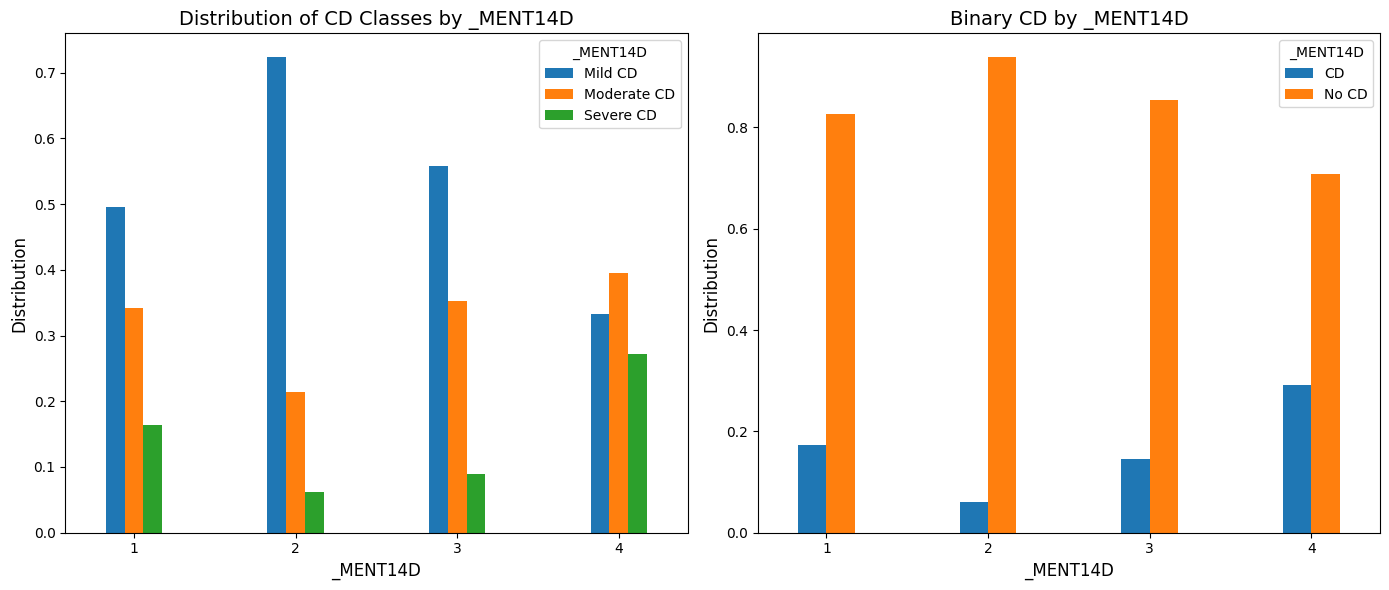

Cramers V for multi-class classification is: 0.25108260715376224
Cramers V for binary classification is: 0.23858259661744335


In [ ]:
mapping246 = {1:"1",2:"2",3:'3',4:'4'}
explore_cat(df_full, '_MENT14D', mapping246, include_refused=True)

In [76]:
#@title Function for continuous variable exploration
def explore_cts(df, feature, none=88, not_sure=77, refused=99):
  subdf = df[[feature, 'Class']]
  print(f'There are {subdf[feature].isna().sum()} missing values, {np.sum(subdf[feature]==not_sure)} not sure values, {np.sum(subdf[feature]==refused)} refused values')

  if np.sum(~subdf[feature].isna()) == 0:
    print("No valid information")

  else:
    subdf.dropna(subset=[feature], inplace=True)
    subdf = subdf[~((subdf[feature]==not_sure) | (subdf[feature]==refused))]
    subdf[feature] = subdf[feature].replace(none, 0)

    desired_order = ['Mild CD', 'Moderate CD', 'Severe CD']
    desired_order2 = ['CD', 'No CD']

    subdf['Binary Classification'] = subdf['Class'].replace({'Mild CD':'CD', 'Moderate CD':'CD', 'Severe CD':'CD'})

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    sns.kdeplot(data=subdf[(subdf['Class']!='No CD')], x=feature, hue='Class', hue_order=desired_order,fill=True,
                common_norm=False, bw_adjust=0.5, ax=axes[0])
    axes[0].set_xlabel(f'{feature}', fontsize=12)
    axes[0].set_ylabel('Density', fontsize=12)
    axes[0].set_title(f'Distribution of {feature} within different CD classes', fontsize=14)
    axes[0].set_xlim(left=0)
    axes[0].legend(title=f'{feature}', labels=desired_order, loc='upper right')

    sns.kdeplot(data=subdf, x=feature, hue='Binary Classification', hue_order=desired_order2,fill=True,
                common_norm=False, bw_adjust=2, ax=axes[1])
    axes[1].set_xlabel(f'{feature}', fontsize=12)
    axes[1].set_ylabel('Density', fontsize=12)
    axes[1].set_title(f'Distribution of {feature} with and without CD', fontsize=14)
    axes[1].set_xlim(left=0)
    axes[1].legend(title=f'{feature}', labels=desired_order2, loc='upper right')

    plt.tight_layout()
    plt.show()

    groups = [group[feature] for name, group in subdf[(subdf['Class']!='No CD')].groupby('Class')]
    f_statistic, p_value = f_oneway(*groups)

    print("p-value for multi-class classification is:", p_value)

    groups2 = [group[feature] for name, group in subdf.groupby('Binary Classification')]
    f_statistic, p_value2 = f_oneway(*groups2)

    print("p-value for binary classification:", p_value2)

  return groups


In [ ]:
# sample function usage
# feature = 'MARIJAN1';

# explore_cts(df_full, feature, none=88, not_sure=98, refused=99)

There are 32441 missing values, 218 not sure values, 225 refused values


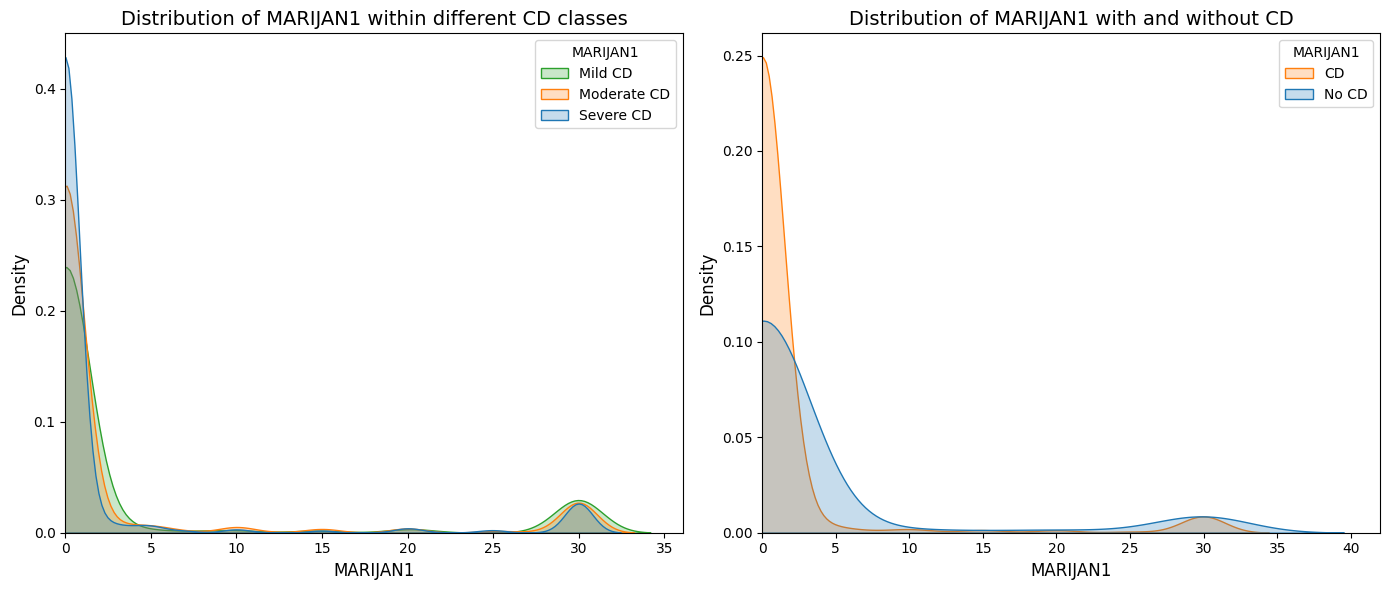

p-value for multi-class classification is: 0.0008450748707151097
p-value for binary classification: 1.5344477991913924e-29


In [77]:
#203 During the past 30 days, on how many days did you use marijuana or hashish?
groups = explore_cts(df_full, 'MARIJAN1', none=88, not_sure=77, refused=99)

In [53]:
group1, group2, group3 = groups
f_oneway(group1, group2, group3)

F_onewayResult(statistic=0.21268047353137284, pvalue=0.8084247668443013)

In [78]:
for group in groups:
  print(np.mean(group))

2.231071228266966
3.0192962542565267
3.6774941995359627


In [ ]:
explore_cts(df_full, '_WT2RAKE', none=88, not_sure=77, refused=99)

There are 36683 missing values, 6 not sure values, 2 refused values


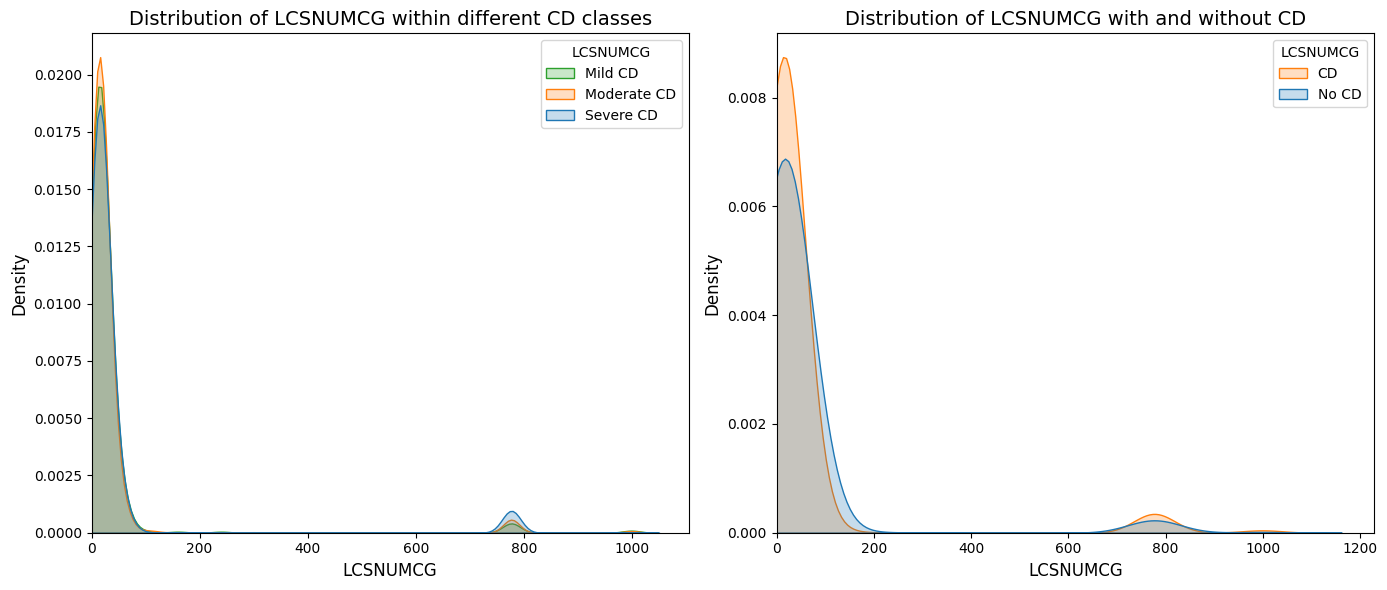

p-value for multi-class classification is: 0.015858375668444856
p-value for binary classification: 0.07313367646836272


[37        20.0
 95        40.0
 115       10.0
 118       30.0
 119       10.0
          ...  
 63381     20.0
 63433     10.0
 63435    777.0
 63480      5.0
 63616      2.0
 Name: LCSNUMCG, Length: 1873, dtype: float64,
 35        5.0
 61       10.0
 88       13.0
 103      20.0
 123      30.0
          ... 
 63266    40.0
 63311     3.0
 63312     3.0
 63402     4.0
 63428     3.0
 Name: LCSNUMCG, Length: 1112, dtype: float64,
 50         5.0
 124      777.0
 184       10.0
 381       10.0
 411        7.0
          ...  
 63044     20.0
 63246     12.0
 63316      3.0
 63394      8.0
 63529     20.0
 Name: LCSNUMCG, Length: 538, dtype: float64]

In [80]:
explore_cts(df_full, 'LCSNUMCG')


There are 0 missing values, 689 not sure values, 70 refused values


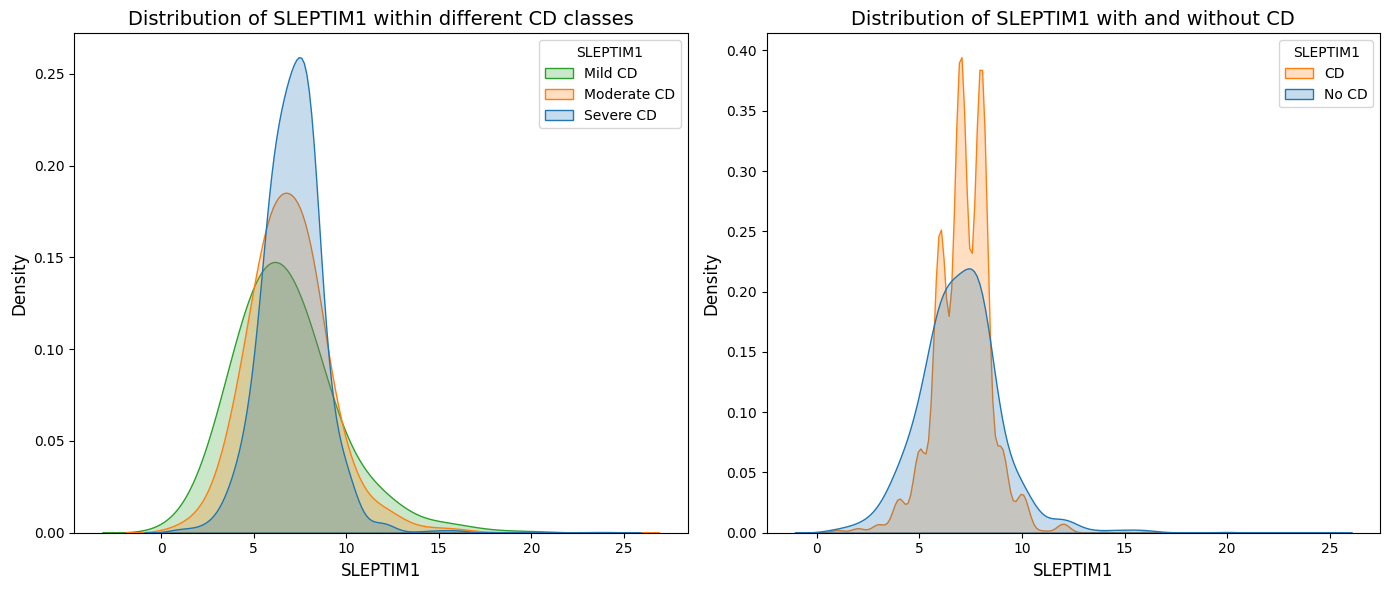

p-value for multi-class classification is: 3.1584512659914636e-06
p-value for binary classification: 3.9212901728858087e-11


In [ ]:
explore_cts(df_full, 'SLEPTIM1', not_sure=77, refused=99)

There are 38608 missing values, 2 not sure values, 0 refused values


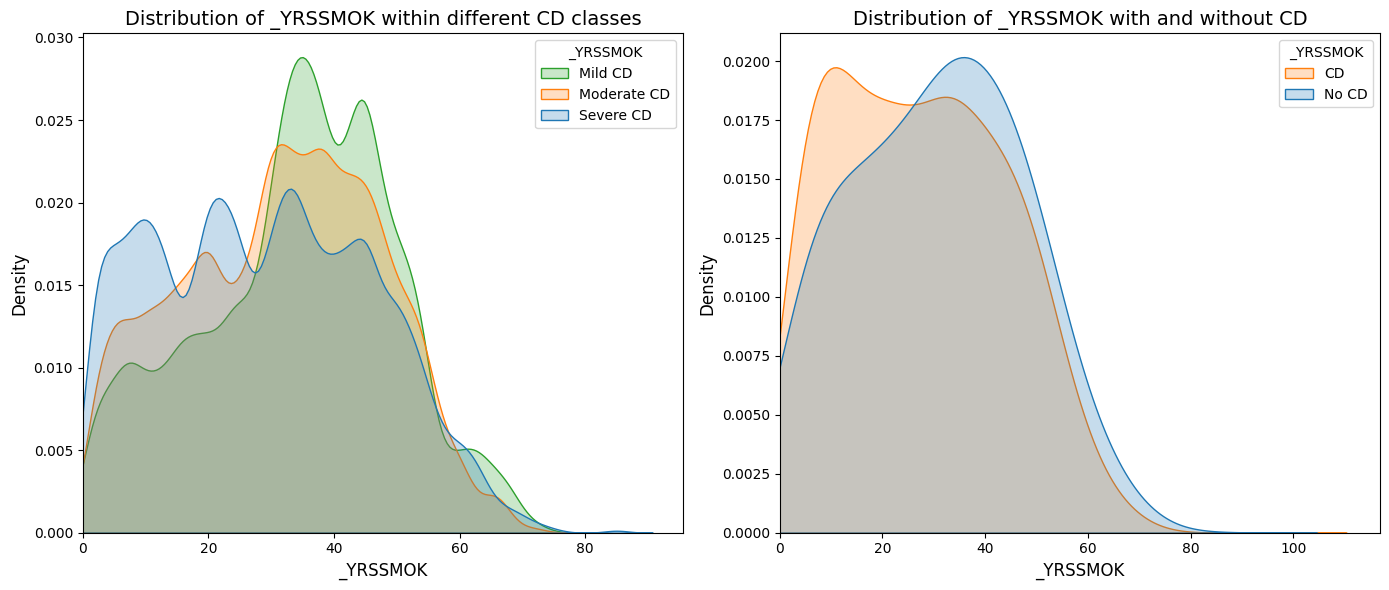

p-value for multi-class classification is: 5.595115949677958e-10
p-value for binary classification: 3.6001184192054294e-22


[37        3.0
 95       41.0
 115      42.0
 118      37.0
 119      40.0
          ... 
 63381    24.0
 63433    33.0
 63435    10.0
 63480     8.0
 63616     1.0
 Name: _YRSSMOK, Length: 1730, dtype: float64,
 35       67.0
 61       32.0
 88       22.0
 103      60.0
 123      34.0
          ... 
 63266    38.0
 63311    54.0
 63312    28.0
 63402     9.0
 63428    29.0
 Name: _YRSSMOK, Length: 1023, dtype: float64,
 50       45.0
 124      44.0
 184      52.0
 381      31.0
 411      28.0
          ... 
 63044    19.0
 63246    16.0
 63316    33.0
 63394    13.0
 63529    64.0
 Name: _YRSSMOK, Length: 497, dtype: float64]

In [81]:
explore_cts(df_full, '_YRSSMOK')
